In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm



# 输入的历史look_back步，和预测未来的T步
look_back = 96
T = 240
epochs = 50   #迭代次数
num_features=6  #输入特证数
embed_dim = 32  #嵌入维度
dense_dim= 64   #隐藏层神经元个数
num_heads = 4   #头数
dropout_rate = 0.01  #失活率
num_blocks = 6  #编码器解码器数
learn_rate = 0.001  #学习率
batch_size = 32 #批大小
step = 3  #步长
dict_path = '../state_dict/transformer_long_best_model.checkpoint'  #模型路径

# 读取数据
dataset = pd.read_csv(r'../data/train_data.csv', usecols=[10,11,12,13,14,15,16])
dataset2 = pd.read_csv(r'../data/test_data.csv', usecols=[10,11,12,13,14,15,16])

# dataset = pd.read_csv(r'../data/train_data.csv', usecols=[16])
# dataset2 = pd.read_csv(r'../data/test_data.csv', usecols=[16])

dataset = dataset.fillna(dataset.mean())
dataset2 = dataset2.fillna(dataset2.mean())


dataX = dataset.values
dataY = dataset['cnt'].values
dataX2 = dataset2.values
dataY2 = dataset2['cnt'].values



num_features=len(dataX[0])  #输入特证数
print(num_features)
print(dataset.info())

7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15219 entries, 0 to 15218
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   temp        15219 non-null  float64
 1   atemp       15219 non-null  float64
 2   hum         15219 non-null  float64
 3   windspeed   15219 non-null  float64
 4   casual      15219 non-null  float64
 5   registered  15219 non-null  float64
 6   cnt         15219 non-null  float64
dtypes: float64(7)
memory usage: 832.4 KB
None


In [2]:

# 归一化数据
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler2 = MinMaxScaler(feature_range=(0, 1))
data_X = scaler1.fit_transform(dataX)
data_Y = scaler2.fit_transform(dataY.reshape(-1, 1))
data_X2 = scaler1.fit_transform(dataX2)
data_Y2 = scaler2.fit_transform(dataY2.reshape(-1, 1))



#划分训练集和测试集，用70%作为训练集，20%作为验证集，10%作为测试集
train_size  = int(len(data_X)*0.8) 
val_size = int(len(data_X)*0.2) 
# test_size = len(data_X) - train_size - val_size

train_X,train_Y = data_X[0:train_size], data_Y[0:train_size]
val_X,val_Y = data_X[train_size:train_size+val_size], data_Y[train_size:train_size+val_size]
test_X,test_Y = data_X2, data_Y2


# 定义输入数据，输出标签数据的格式的函数，并将数据转换为模型可接受的3D格式
def create_dataset(datasetX, datasetY, look_back=1, T=1):
    dataX, dataY = [], []
    for i in range(0, len(datasetX) - look_back -T, step):
        a = datasetX[i:(i + look_back), :]
        dataX.append(a)
        if T==1:
            dataY.append(datasetY[i + look_back])
        else:
            dataY.append(datasetY[i + look_back:i + look_back+T,0])
    return np.array(dataX), np.array(dataY)


In [3]:

# 准备训练集和测试集的数据
trainX, trainY = create_dataset(train_X, train_Y, look_back, T)
valX, valY = create_dataset(val_X,val_Y, look_back, T)
testX, testY = create_dataset(test_X, test_Y, look_back, T)

# 转换为PyTorch的Tensor数据
trainX = torch.Tensor(trainX)
trainY = torch.Tensor(trainY)
valX = torch.Tensor(valX)
valY = torch.Tensor(valY)
testX = torch.Tensor(testX)
testY = torch.Tensor(testY)


In [4]:
testX.shape

torch.Size([608, 96, 7])

In [5]:
21*96

2016

100%|██████████| 29/29 [00:00<00:00, 98.95it/s] 


Epoch 1/50, Train Loss: 0.0273, Val Loss: 0.1028


100%|██████████| 29/29 [00:00<00:00, 77.04it/s]


Epoch 2/50, Train Loss: 0.0433, Val Loss: 0.0976


100%|██████████| 29/29 [00:00<00:00, 73.21it/s]


Epoch 3/50, Train Loss: 0.0170, Val Loss: 0.0681


100%|██████████| 29/29 [00:00<00:00, 71.32it/s]


Epoch 4/50, Train Loss: 0.0146, Val Loss: 0.0339


100%|██████████| 29/29 [00:00<00:00, 71.42it/s]


Epoch 5/50, Train Loss: 0.0126, Val Loss: 0.0390


100%|██████████| 29/29 [00:00<00:00, 76.69it/s]


Epoch 6/50, Train Loss: 0.0209, Val Loss: 0.0364


100%|██████████| 29/29 [00:00<00:00, 82.35it/s]


Epoch 7/50, Train Loss: 0.0121, Val Loss: 0.0463


100%|██████████| 29/29 [00:00<00:00, 75.58it/s]


Epoch 8/50, Train Loss: 0.0134, Val Loss: 0.0407


100%|██████████| 29/29 [00:00<00:00, 75.49it/s]


Epoch 9/50, Train Loss: 0.0164, Val Loss: 0.0305


100%|██████████| 29/29 [00:00<00:00, 84.01it/s]


Epoch 10/50, Train Loss: 0.0111, Val Loss: 0.0294


100%|██████████| 29/29 [00:00<00:00, 75.82it/s]


Epoch 11/50, Train Loss: 0.0109, Val Loss: 0.0321


100%|██████████| 29/29 [00:00<00:00, 75.04it/s]


Epoch 12/50, Train Loss: 0.0095, Val Loss: 0.0317


100%|██████████| 29/29 [00:00<00:00, 78.41it/s]


Epoch 13/50, Train Loss: 0.0099, Val Loss: 0.0231


100%|██████████| 29/29 [00:00<00:00, 72.04it/s]


Epoch 14/50, Train Loss: 0.0095, Val Loss: 0.0269


100%|██████████| 29/29 [00:00<00:00, 72.45it/s]


Epoch 15/50, Train Loss: 0.0088, Val Loss: 0.0250


100%|██████████| 29/29 [00:00<00:00, 70.76it/s]


Epoch 16/50, Train Loss: 0.0100, Val Loss: 0.0281


100%|██████████| 29/29 [00:00<00:00, 70.72it/s]


Epoch 17/50, Train Loss: 0.0068, Val Loss: 0.0259


100%|██████████| 29/29 [00:00<00:00, 77.15it/s]


Epoch 18/50, Train Loss: 0.0100, Val Loss: 0.0358


100%|██████████| 29/29 [00:00<00:00, 75.97it/s]


Epoch 19/50, Train Loss: 0.0119, Val Loss: 0.0307


100%|██████████| 29/29 [00:00<00:00, 73.52it/s]


Epoch 20/50, Train Loss: 0.0137, Val Loss: 0.0309


100%|██████████| 29/29 [00:00<00:00, 73.62it/s]


Epoch 21/50, Train Loss: 0.0080, Val Loss: 0.0217


100%|██████████| 29/29 [00:00<00:00, 78.31it/s]


Epoch 22/50, Train Loss: 0.0087, Val Loss: 0.0242


100%|██████████| 29/29 [00:00<00:00, 74.55it/s]


Epoch 23/50, Train Loss: 0.0077, Val Loss: 0.0224


100%|██████████| 29/29 [00:00<00:00, 73.44it/s]


Epoch 24/50, Train Loss: 0.0080, Val Loss: 0.0218


100%|██████████| 29/29 [00:00<00:00, 70.93it/s]


Epoch 25/50, Train Loss: 0.0072, Val Loss: 0.0211


100%|██████████| 29/29 [00:00<00:00, 74.28it/s]


Epoch 26/50, Train Loss: 0.0072, Val Loss: 0.0252


100%|██████████| 29/29 [00:00<00:00, 99.43it/s]


Epoch 27/50, Train Loss: 0.0069, Val Loss: 0.0312


100%|██████████| 29/29 [00:00<00:00, 101.16it/s]


Epoch 28/50, Train Loss: 0.0097, Val Loss: 0.0288


100%|██████████| 29/29 [00:00<00:00, 98.22it/s]


Epoch 29/50, Train Loss: 0.0079, Val Loss: 0.0186


100%|██████████| 29/29 [00:00<00:00, 98.10it/s]


Epoch 30/50, Train Loss: 0.0088, Val Loss: 0.0252


100%|██████████| 29/29 [00:00<00:00, 97.43it/s]


Epoch 31/50, Train Loss: 0.0084, Val Loss: 0.0266


100%|██████████| 29/29 [00:00<00:00, 100.13it/s]


Epoch 32/50, Train Loss: 0.0068, Val Loss: 0.0270


100%|██████████| 29/29 [00:00<00:00, 101.50it/s]


Epoch 33/50, Train Loss: 0.0069, Val Loss: 0.0283


100%|██████████| 29/29 [00:00<00:00, 96.37it/s]


Epoch 34/50, Train Loss: 0.0072, Val Loss: 0.0301


100%|██████████| 29/29 [00:00<00:00, 97.77it/s]


Epoch 35/50, Train Loss: 0.0073, Val Loss: 0.0271


100%|██████████| 29/29 [00:00<00:00, 101.15it/s]


Epoch 36/50, Train Loss: 0.0085, Val Loss: 0.0271


100%|██████████| 29/29 [00:00<00:00, 101.65it/s]


Epoch 37/50, Train Loss: 0.0070, Val Loss: 0.0283


100%|██████████| 29/29 [00:00<00:00, 101.03it/s]


Epoch 38/50, Train Loss: 0.0058, Val Loss: 0.0242


100%|██████████| 29/29 [00:00<00:00, 110.41it/s]


Epoch 39/50, Train Loss: 0.0077, Val Loss: 0.0286


100%|██████████| 29/29 [00:00<00:00, 108.49it/s]


Epoch 40/50, Train Loss: 0.0065, Val Loss: 0.0301


100%|██████████| 29/29 [00:00<00:00, 111.84it/s]


Epoch 41/50, Train Loss: 0.0069, Val Loss: 0.0266


100%|██████████| 29/29 [00:00<00:00, 114.78it/s]


Epoch 42/50, Train Loss: 0.0063, Val Loss: 0.0281


100%|██████████| 29/29 [00:00<00:00, 112.98it/s]


Epoch 43/50, Train Loss: 0.0064, Val Loss: 0.0331


100%|██████████| 29/29 [00:00<00:00, 114.14it/s]


Epoch 44/50, Train Loss: 0.0069, Val Loss: 0.0282


100%|██████████| 29/29 [00:00<00:00, 109.21it/s]


Epoch 45/50, Train Loss: 0.0057, Val Loss: 0.0298


100%|██████████| 29/29 [00:00<00:00, 112.33it/s]


Epoch 46/50, Train Loss: 0.0072, Val Loss: 0.0341


100%|██████████| 29/29 [00:00<00:00, 109.47it/s]


Epoch 47/50, Train Loss: 0.0068, Val Loss: 0.0326


100%|██████████| 29/29 [00:00<00:00, 114.15it/s]


Epoch 48/50, Train Loss: 0.0058, Val Loss: 0.0300


100%|██████████| 29/29 [00:00<00:00, 111.61it/s]


Epoch 49/50, Train Loss: 0.0053, Val Loss: 0.0382


100%|██████████| 29/29 [00:00<00:00, 113.15it/s]


Epoch 50/50, Train Loss: 0.0058, Val Loss: 0.0332


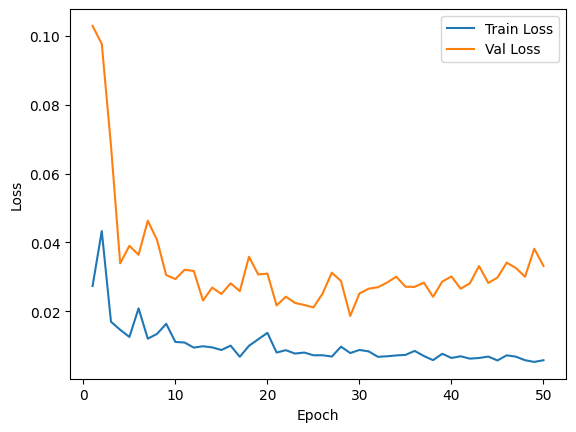

In [6]:

# 构建Transformer模型
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate):
        super(TransformerEncoder, self).__init__()

        self.mha = nn.MultiheadAttention(embed_dim, num_heads)
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.dense1 = nn.Linear(embed_dim, dense_dim)
        self.dense2 = nn.Linear(dense_dim, embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, inputs):
        attn_output, _ = self.mha(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)

        dense_output = self.dense1(out1)
        dense_output = self.dense2(dense_output)
        dense_output = self.dropout2(dense_output)
        out2 = self.layernorm2(out1 + dense_output)

        return out2

class TransformerDecoder(nn.Module):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate):
        super(TransformerDecoder, self).__init__()

        self.mha1 = nn.MultiheadAttention(embed_dim, num_heads)
        self.mha2 = nn.MultiheadAttention(embed_dim, num_heads)
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.layernorm3 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.dense1 = nn.Linear(embed_dim, dense_dim)
        self.dense2 = nn.Linear(dense_dim, embed_dim)
        self.layernorm4 = nn.LayerNorm(embed_dim)
        self.dropout4 = nn.Dropout(dropout_rate)

    def forward(self, inputs, encoder_outputs):
        attn1, _ = self.mha1(inputs, inputs, inputs)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(inputs + attn1)

        attn2, _ = self.mha2(out1, encoder_outputs, encoder_outputs)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(out1 + attn2)

        dense_output = self.dense1(out2)
        dense_output = self.dense2(dense_output)
        dense_output = self.dropout3(dense_output)
        out3 = self.layernorm3(out2 + dense_output)

        decoder_output = self.dense1(out3)
        decoder_output = self.dense2(decoder_output)
        decoder_output = self.dropout4(decoder_output)
        out4 = self.layernorm4(out3 + decoder_output)

        return out4

class Transformer(nn.Module):
    def __init__(self, num_features,embed_dim, dense_dim, num_heads, dropout_rate, num_blocks, output_sequence_length):
        super(Transformer, self).__init__()

        self.embedding = nn.Linear(num_features, embed_dim)
        self.transformer_encoder = nn.ModuleList([TransformerEncoder(embed_dim, dense_dim, num_heads, dropout_rate) for _ in range(num_blocks)])
        self.transformer_decoder = nn.ModuleList([TransformerDecoder(embed_dim, dense_dim, num_heads, dropout_rate) for _ in range(num_blocks)])
        self.final_layer = nn.Linear(embed_dim * look_back, output_sequence_length)

    def forward(self, inputs):
        encoder_inputs = inputs
        decoder_inputs = inputs

        encoder_outputs = self.embedding(encoder_inputs)
        for i in range(len(self.transformer_encoder)):
            encoder_outputs = self.transformer_encoder[i](encoder_outputs)

        decoder_outputs = self.embedding(decoder_inputs)
        for i in range(len(self.transformer_decoder)):
            decoder_outputs = self.transformer_decoder[i](decoder_outputs, encoder_outputs)

        decoder_outputs = decoder_outputs.view(-1, decoder_outputs.shape[1] * decoder_outputs.shape[2])
        decoder_outputs = self.final_layer(decoder_outputs)
        decoder_outputs = decoder_outputs.view(-1, T)
        return decoder_outputs

# 定义训练集和测试集的数据加载器
class MyDataset(Dataset):
    def __init__(self, data_X, data_Y):
        self.data_X = data_X
        self.data_Y = data_Y

    def __getitem__(self, index):
        x = self.data_X[index]
        y = self.data_Y[index]
        return x, y

    def __len__(self):
        return len(self.data_X)

train_dataset = MyDataset(trainX, trainY)
val_dataset = MyDataset(valX, valY)
test_dataset = MyDataset(testX, testY)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 创建模型实例
model = Transformer(num_features=num_features,embed_dim=embed_dim, dense_dim=dense_dim, num_heads=num_heads, dropout_rate=dropout_rate, num_blocks=num_blocks, output_sequence_length=T)
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
model.to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

train_losses = []
val_losses = []
best_val_loss = float('inf')
# 训练模型
for epoch in range(epochs):
    model.train()
    for inputs, labels in tqdm(train_loader ,position=0):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

    # 在验证集上计算损失
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader ,position=0):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.forward(inputs)
            val_loss = criterion(outputs, labels)
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())  
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        torch.save(model.state_dict(), dict_path)
            
    # 每个epoch打印一次训练和验证损失
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# 可视化损失函数
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:

# 测试模型
model.load_state_dict(torch.load(dict_path))
model.eval()
predictions = []
i = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader ,position=0):
        inputs = inputs.to(device)

        if i%(96//step) == 0:
            outputs = model(inputs)
            predictions.extend(outputs.cpu().numpy())

predictions = np.array(predictions).reshape(-1, 1)
labels = (testY.cpu().numpy()).reshape(-1, 1)

#测试集数据反归一化
# predictions = scaler2.inverse_transform(predictions)
# predictions[predictions < 0] = 0
# labels = scaler2.inverse_transform(labels)

# 计算模型的评价指标
r2 = r2_score(labels, predictions)
mae = mean_absolute_error(labels, predictions)
rmse = np.sqrt(mean_squared_error(labels, predictions))
mape = np.mean(np.abs((labels - predictions) / labels))

# 打印模型的评价指标
print('R2:', r2)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

# 可视化预测结果
# plt.figure(figsize=(16, 12), dpi=300)
# plt.xlabel('', fontsize=13)
# plt.ylabel('', fontsize=13)
# plt.plot(labels, label='True Value')
# plt.plot(predictions, label='Prediction Value')
# plt.legend(fontsize=13)
# plt.show()


100%|██████████| 19/19 [00:00<00:00, 117.08it/s]

R2: 0.318400541582606
MAE: 0.12020641
RMSE: 0.1705375
MAPE: inf



/tmp/ipykernel_2864054/3501040622.py:26: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((labels - predictions) / labels))


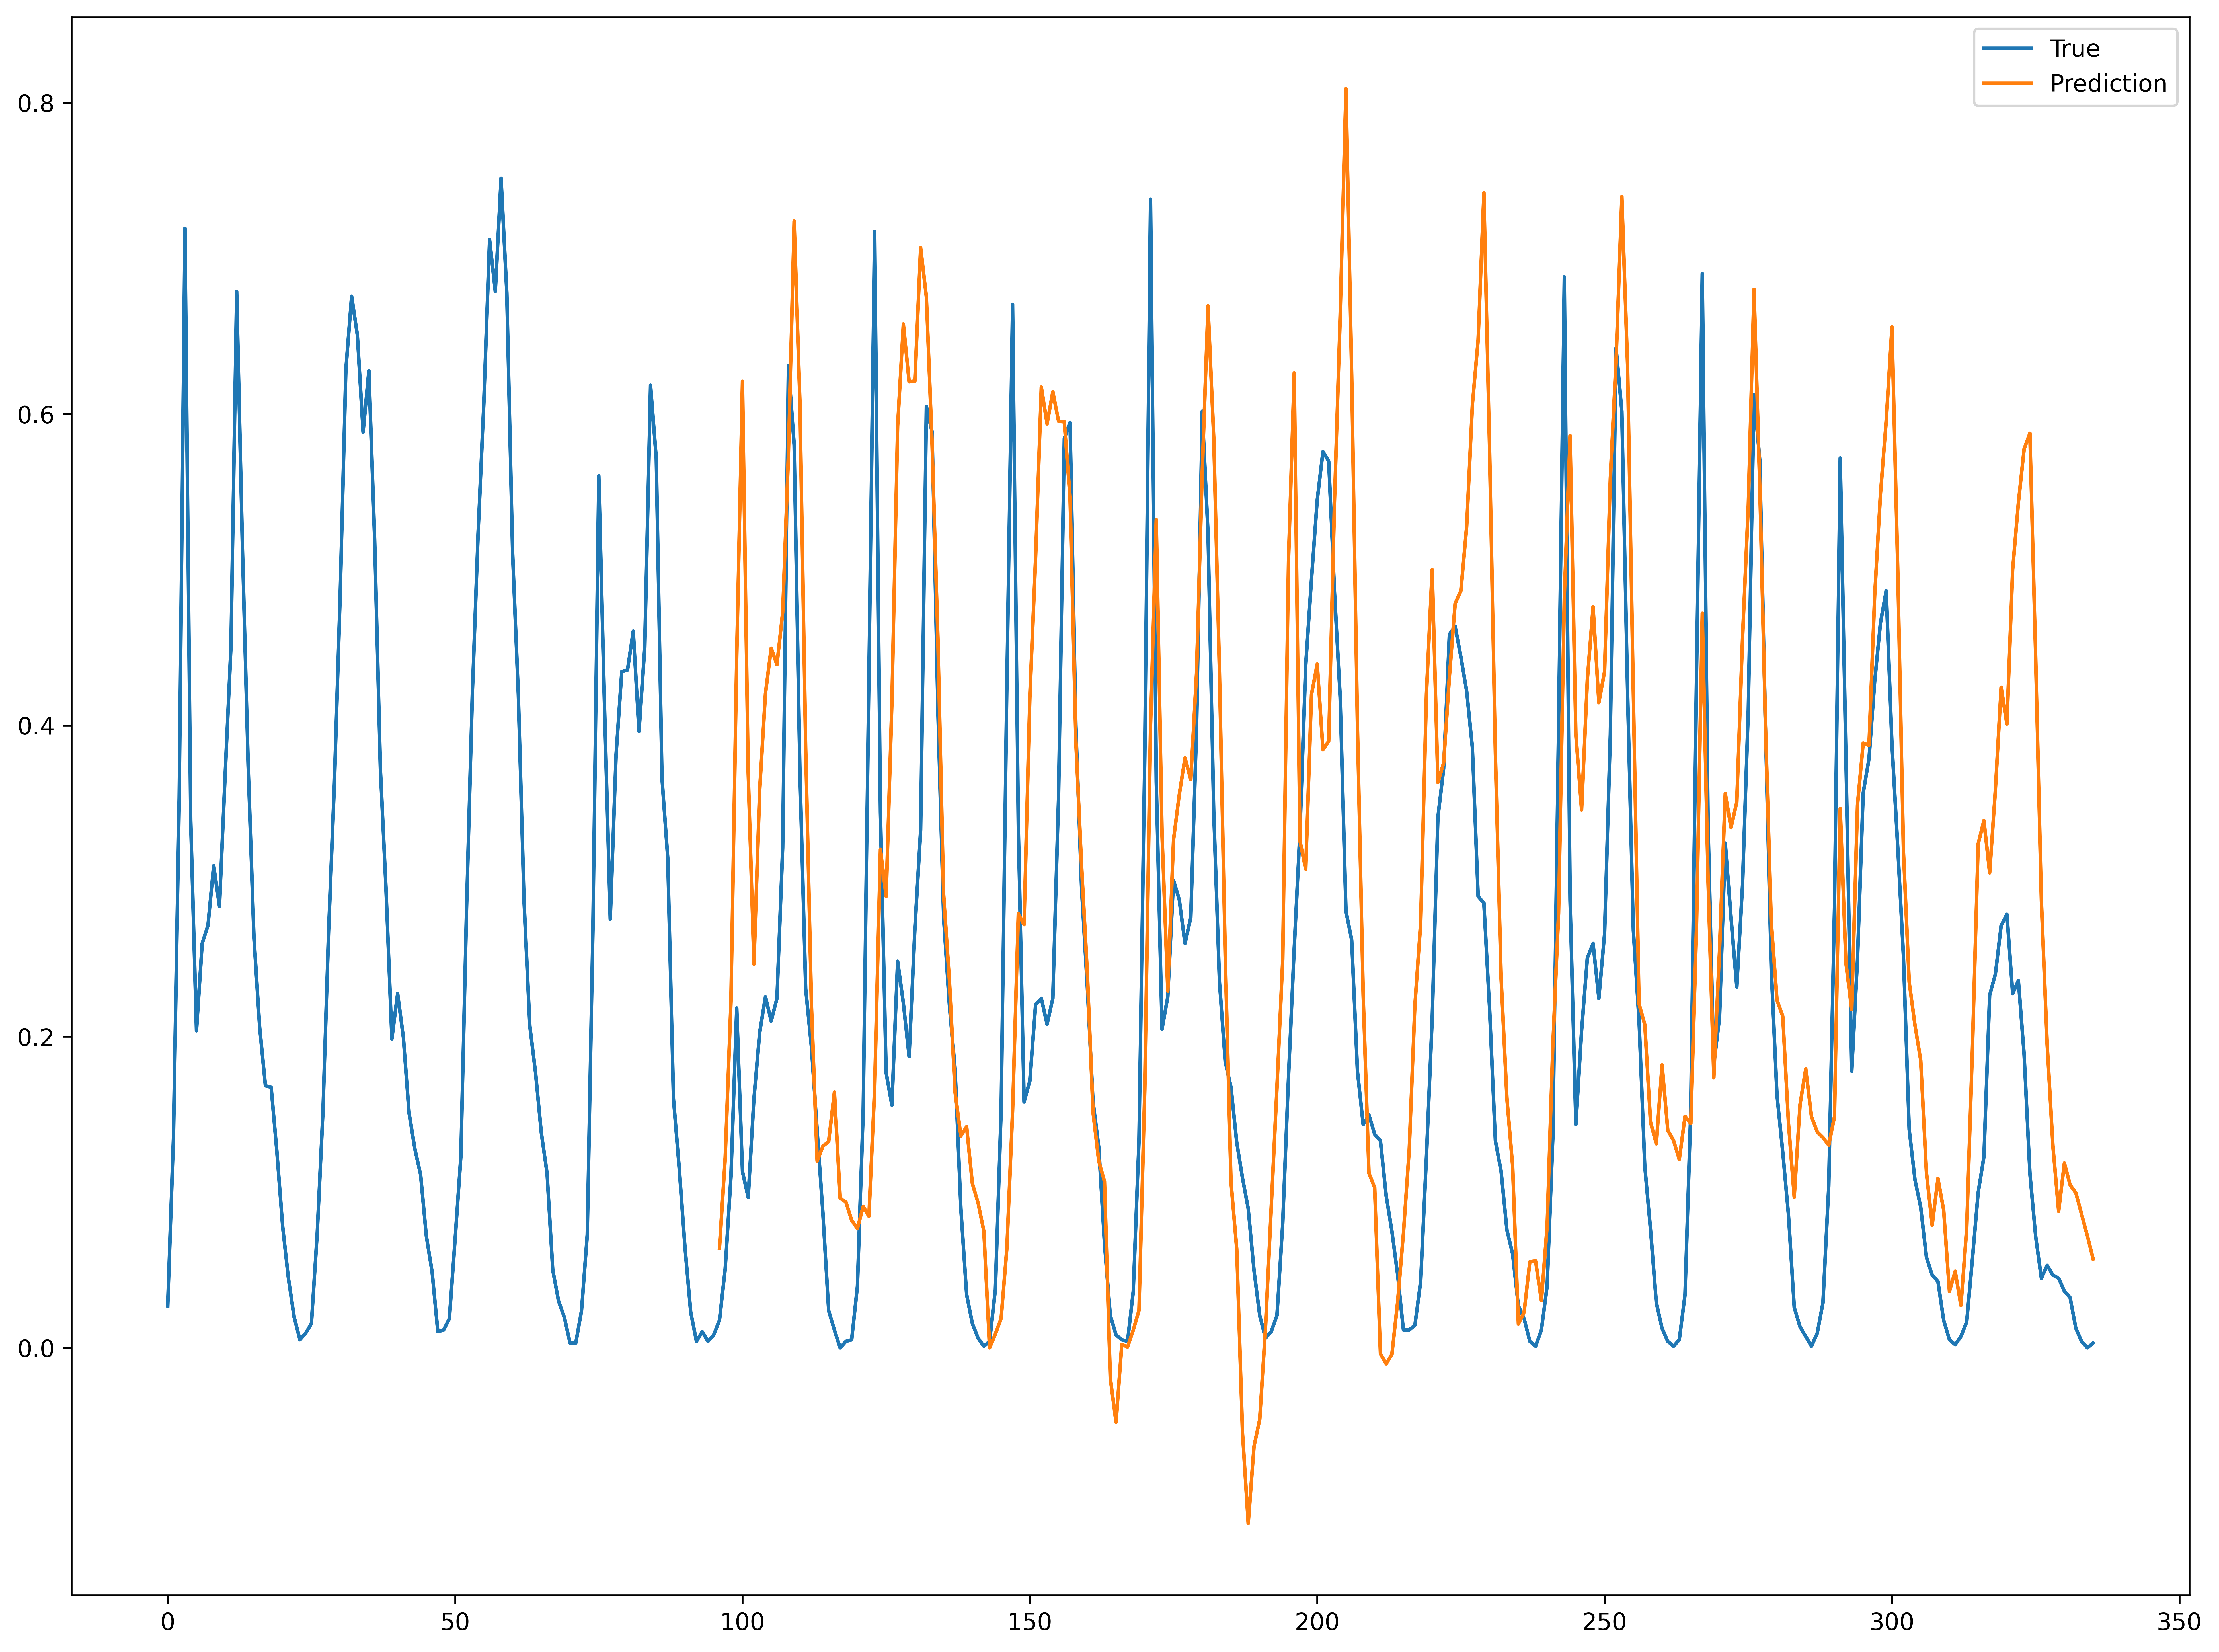

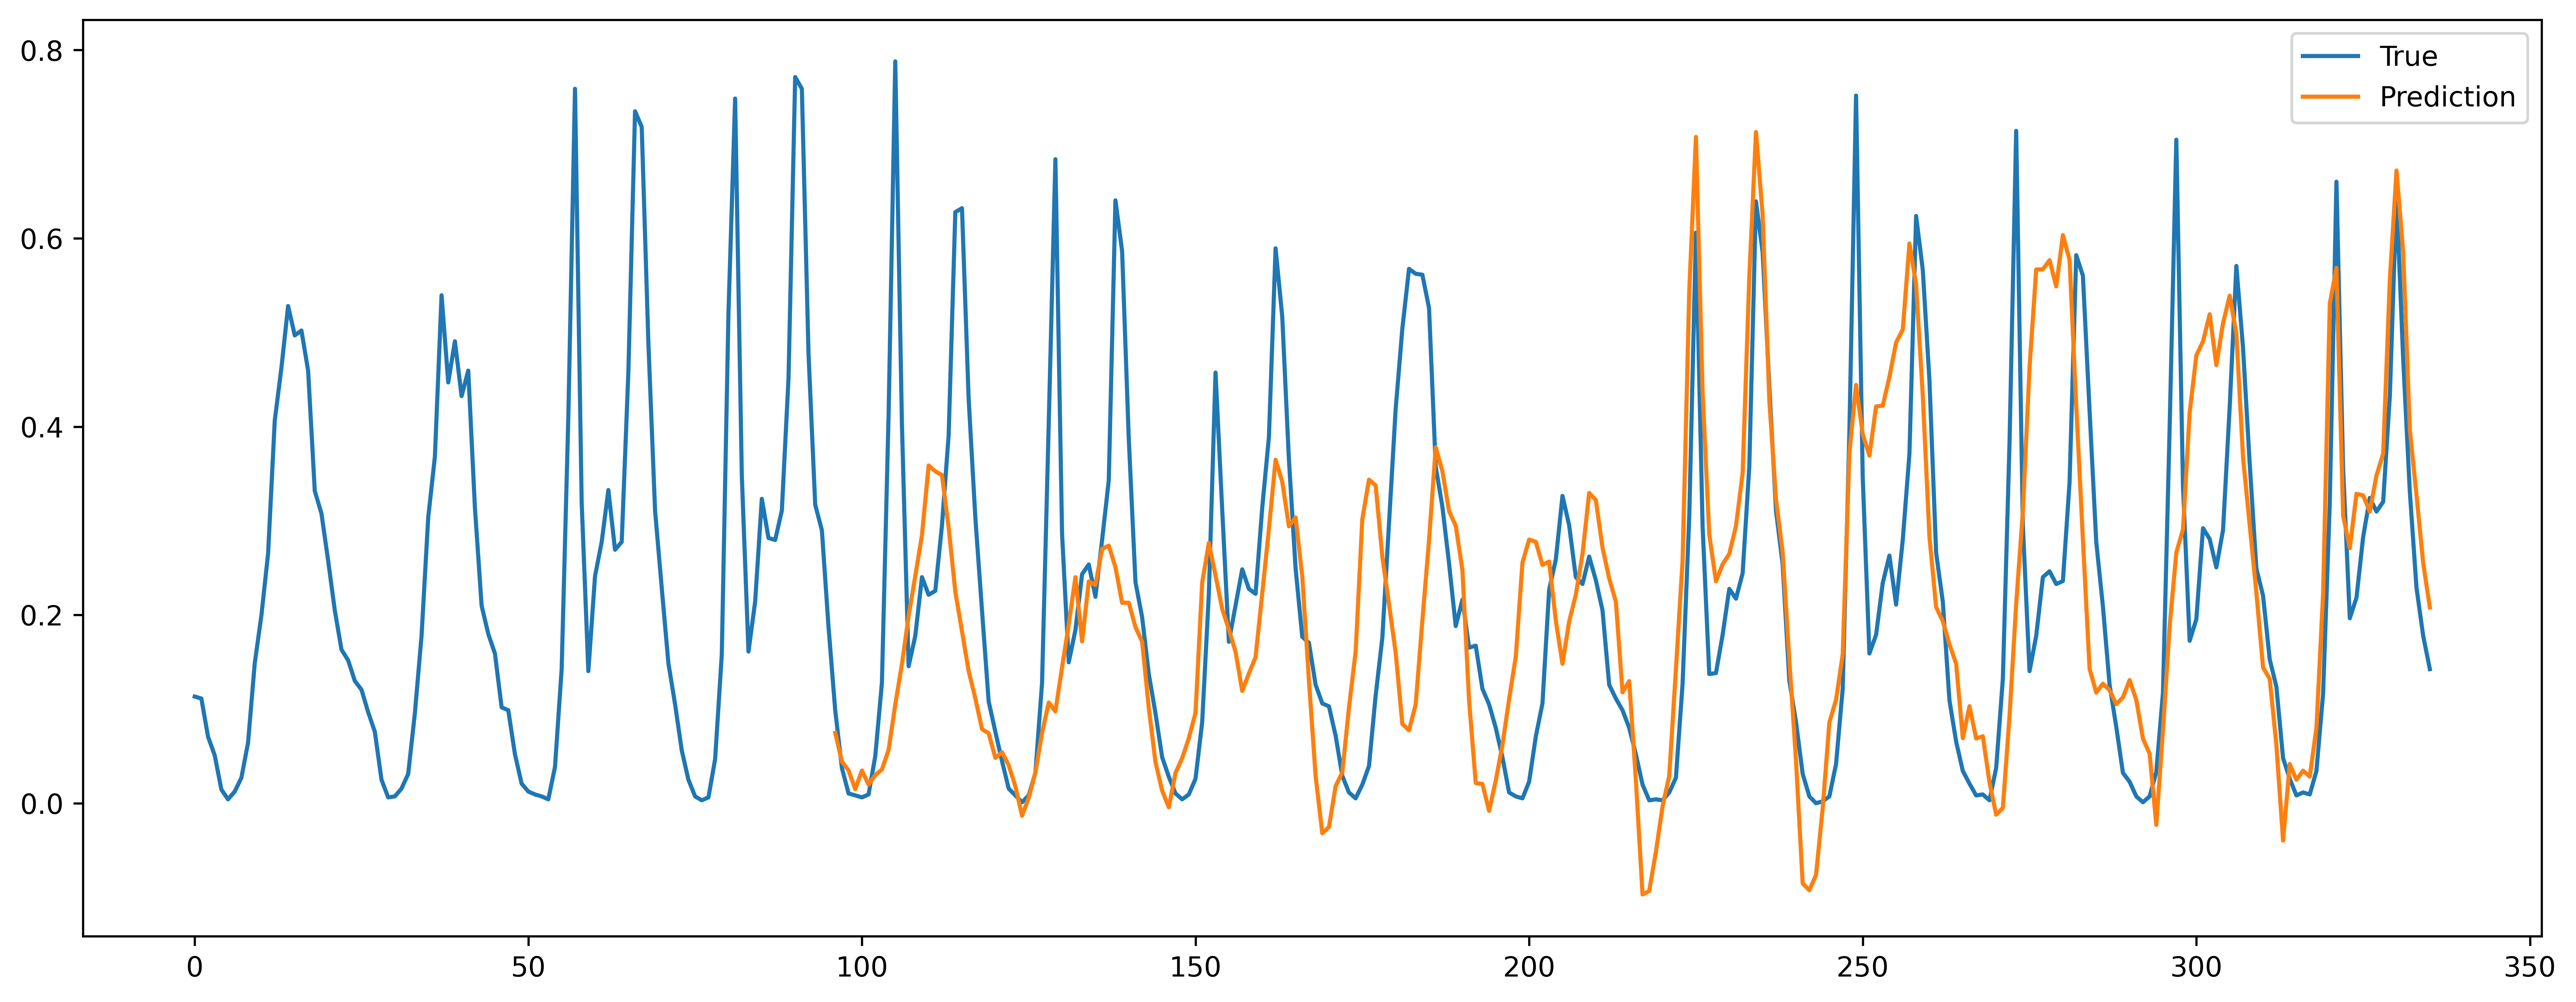

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 定义数组
y1 = [1, 2, 3, 4]  # 第一条曲线
y2 = [3, 4]        # 第二条曲线

labels1 = labels
predictions1 = predictions






# 找到模 4 为 0 的索引位置
indices = np.where(np.arange(len(labels1)) % (T*T // step) == 0)[0]

# 提取每个位置开头的两个元素
result = np.concatenate([labels1[i:i + T] for i in indices if i  + T-1 < len(labels1)])
predictions_f = np.concatenate([predictions1[i:i + T] for i in indices if i  + T-1 < len(labels1)])
# print(result)  # 输出: [10 20 50 60 90 100]




i = 800
y1 = np.concatenate((result[i:i+96], result[i+96:i+96+T]))
y2 = predictions_f[i:i+T]

best_i = -1
mse = float('inf')
for i in range(result.shape[0]-96-T):
    tmp = mean_absolute_error(result[i+96:i+96+T], predictions_f[i:i+T])
    if tmp < mse:
        mse = tmp
        best_i = i



# 计算两条曲线的 x 轴范围
x1 = np.arange(len(y1))  # x1: [0, 1, 2, 3]
x2 = np.arange(len(y1) - len(y2), len(y1))  # x2: [2, 3]
plt.figure(figsize=(16, 12), dpi=600)
# 绘制曲线
plt.plot(x1, y1, label="True")  # 第一条曲线
plt.plot(x2, y2, label="Prediction")  # 第二条曲线

# 添加图例和标题
plt.legend()

# plt.xlabel("X")
# plt.ylabel("Y")

# 显示图形
plt.show()


i = best_i
y1 = np.concatenate((result[i:i+96], result[i+96:i+96+T]))
y2 = predictions_f[i:i+T]

# 计算两条曲线的 x 轴范围
x1 = np.arange(len(y1))  # x1: [0, 1, 2, 3]
x2 = np.arange(len(y1) - len(y2), len(y1))  # x2: [2, 3]
plt.figure(figsize=(16, 6), dpi=600)
# 绘制曲线
plt.plot(x1, y1, label="True")  # 第一条曲线
plt.plot(x2, y2, label="Prediction")  # 第二条曲线

# 添加图例和标题
plt.legend()

# plt.xlabel("X")
# plt.ylabel("Y")

# 显示图形
plt.show()

In [9]:
i

1321

In [10]:
mse

0.120811835

In [11]:
len(indices)*192

1536

In [12]:
result.shape

(1920, 1)

In [13]:
predictions_f.shape

(1920, 1)